In [1]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt

import qsotools.fiducial as fid
import qsotools.specops as so
import qsotools.io.kodiaq as kod

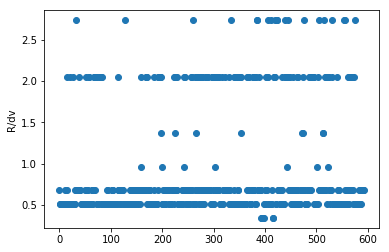

In [2]:
# Plot R/dv ratio for all observations
kmt = ascii.read("../tables/master_kodiaq_table.tsv")
kmt['Rkms'] = fid.LIGHT_SPEED / kmt['SPECRES'] / fid.ONE_SIGMA_2_FWHM

plt.plot(kmt['Rkms']/kmt['dv'], 'o')
plt.ylabel("R/dv")
plt.show()

In [3]:
np.sum(kmt['Rkms']/kmt['dv']>1)

137

In [4]:
# Find the spectra that have the max s/n in Lya forest
spec_list = kod.getKODIAQLyaMaxS2NObsList("/Users/nk452/repos/data/KODIAQ_Data/KODIAQ_DR2_20170619/", \
                                          "../tables/kodiaq_asu.tsv")

In [5]:
# Get histograms of Lya forest pixel statistics such as redshift distribution, mean flux and error.
z1 = 1.5
nz = 21
dz = 0.2

redshifts      = z1 + dz * np.arange(nz)
redshift_edges = z1 + dz * (np.arange(nz+1)-0.5)

total_flux = np.zeros(nz)
total_error = np.zeros(nz)
total_error2 = np.zeros(nz)
counts = np.zeros(nz+2)
z_hist = np.zeros(nz)

for sp in spec_list:
    lyman_alpha_ind = np.logical_and(sp.wave >= fid.LYA_FIRST_WVL * (1+sp.z_qso), \
                                     sp.wave <= fid.LYA_LAST_WVL  * (1+sp.z_qso))

    ci, zi, fi, ei, e2i = so.getStats(sp.wave[lyman_alpha_ind], sp.flux[lyman_alpha_ind], \
                                 sp.error[lyman_alpha_ind], redshift_edges)
    
    z_hist += zi
    total_flux += fi
    total_error += ei
    total_error2 += e2i
    counts += ci

Text(0.5,1,'Histogram of Pixel Redshifts')

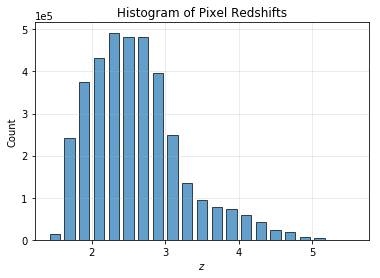

In [6]:
# Plot histogram of pixel redshifts
plt.bar(redshifts, z_hist,align='center', width=dz*0.7, linewidth=1, ec='black', alpha=0.7)
plt.grid(True, which='major', alpha=0.3)
plt.xlabel(r'$z$')
plt.ylabel('Count')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Histogram of Pixel Redshifts')

/Users/nk452/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/nk452/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nk452/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


(0, 1)

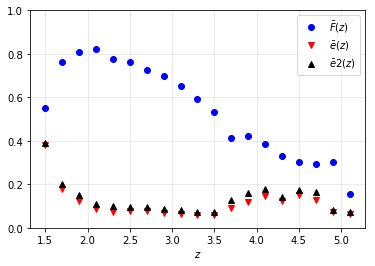

In [7]:
# Plot mean flux and mean error wrt redshift
mean_flux = total_flux / counts[1:-1]
mean_error = total_error / counts[1:-1]
mean_error2 = np.sqrt(total_error2 / counts[1:-1])

plt.plot(redshifts, mean_flux, "bo", label=r"$\bar F(z)$")
plt.plot(redshifts, mean_error, "rv", label=r"$\bar e(z)$")
plt.plot(redshifts, mean_error2, "k^", label=r"$\bar e2(z)$")
plt.grid(True, which='major', alpha=0.3)
plt.legend()
plt.xlabel(r'$z$')
plt.ylim(0,1)

(0, 0.3)

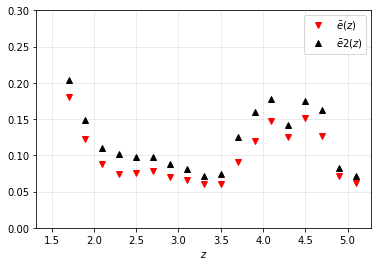

In [8]:
# Compare simple average error and squared average error
plt.plot(redshifts, mean_error, "rv", label=r"$\bar e(z)$")
plt.plot(redshifts, mean_error2, "k^", label=r"$\bar e2(z)$")
plt.grid(True, which='major', alpha=0.3)
plt.legend()
plt.xlabel(r'$z$')
plt.ylim(0,0.3)

(0, 1)

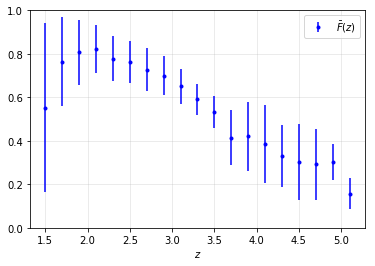

In [9]:
# Take squared error average as error on mean flux
plt.errorbar(redshifts, mean_flux, yerr=mean_error2, fmt="b.", label=r"$\bar F(z)$")
plt.grid(True, which='major', alpha=0.3)
plt.legend()
plt.xlabel(r'$z$')
plt.ylim(0,1)

In [17]:
# Fit mean flux 
# Cut redshift range
ind = np.logical_and(1.7<redshifts, redshifts<4.0)
fit_F = mean_flux[ind]
fit_e = mean_error2[ind]
fit_z = redshifts[ind]

pnew, pcov = fid.fitBecker13MeanFlux(fit_z, fit_F, fit_e)

z0 is fixed to 3.5
tau0     = 6.017e-01
beta     = 6.054e+00
C        = 1.664e-01

chisq = 0.22, dof =  8


/Users/nk452/repos/qsotools/py/qsotools/fiducial.py:144: RuntimeWarning: invalid value encountered in power
  tau_eff = C + tau0 * np.power(x0, beta)


(0, 1)

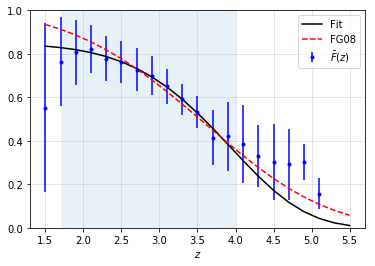

In [18]:
# Over plot fit and data
plt.errorbar(redshifts, mean_flux, yerr=mean_error2, fmt="b.", label=r"$\bar F(z)$")
plt.plot(redshifts, fid.evaluateBecker13MeanFlux(redshifts, *pnew), 'k-', label="Fit")
plt.plot(redshifts, fid.meanFluxFG08(redshifts), 'r--', label='FG08')
plt.grid(True, which='major', alpha=0.4)
plt.axvspan(1.7, 4.0, alpha=0.1)
plt.legend()
plt.xlabel(r'$z$')
plt.ylim(0,1)